Getting familiar with DR. Mussman's research assignment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import sklearn
import re

Now that I am able to populate the training and testing arrays for the values, I need to test the relative error for the different values of alpha.


In [2]:
# --- imports -------------------------------------------------------------
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model

# Train years: 2010–2019. Test years: 2021–2023.
TRAIN_YEARS_PERCENT = list(range(2010, 2017))  # 2010–2016: percentages
TRAIN_YEARS_COUNT = [2017, 2018, 2019] # 2017–2019: counts
TEST_YEARS_COUNT = [2021, 2022, 2023] # 2021–2023: counts

def normalize_labels(series):
    """Replace NBSP with regular space using str.translate (no regex)."""
    series = series.astype(str)
    series = series.str.replace("\u00A0", " ", regex=False)  # "\u00A0" is NBSP
    return series

def get_age_rows(df):
    labels = normalize_labels(df["Label (Grouping)"])
    stripped = labels.str.strip()
    start_idx = stripped.index[stripped.eq("Under 5 years")][0]
    end_idx = start_idx + 18
    age_rows = df.iloc[start_idx:end_idx]  # 18 rows
    return age_rows

def total_cols(df):
    total_estimate_columns = []
    for col in df.columns:
        if col.endswith("!!Total!!Estimate"):
            total_estimate_columns.append(col)
    return total_estimate_columns

def build_state_age_matrix_percent(csv_path):
    df = pd.read_csv(csv_path)
    # age_rows = get_simple_age_block(df)
    age_rows = get_age_rows(df)
    tot_cols = total_cols(df)
    age_pct_df = age_rows[tot_cols].replace('[%,]', '', regex=True).astype(float)
    age_mat = age_pct_df.T.reset_index(drop=True).to_numpy(dtype=float) * 0.01
    return age_mat

def build_state_age_matrix_counts(csv_path):
    df = pd.read_csv(csv_path)
    age_rows = get_age_rows(df)
    tot_cols = total_cols(df)
    age_cnt_df = age_rows[tot_cols].replace(',', '', regex=True).astype(int)
    age_mat = age_cnt_df.T.reset_index(drop=True).to_numpy(dtype=int)
    return age_mat

def totals_from_file(csv_path):
    df = pd.read_csv(csv_path)
    totals_cols = total_cols(df)
    totals = (df.filter(items=totals_cols).iloc[0])
    totals_no_commas = totals.replace(",", "", regex=True)
    int_casted_totals = totals_no_commas.astype(int).to_numpy()
    return int_casted_totals  # (52,)

def make_file_path(year):
    year_string = f"ACSST1Y{year}.S0101.csv"
    path = os.path.join("data", year_string)
    return path

def load_year_matrix(year):
    path = make_file_path(year)
    if year <= 2016:
        age_mat_pct = build_state_age_matrix_percent(path) # (52,18) 
        totals = totals_from_file(path).reshape(-1, 1)
        age_matrix = (totals * age_mat_pct).astype(float)
    else:
        age_matrix = build_state_age_matrix_counts(path).astype(float)  # (52,18)
    return age_matrix

def build_train_array():
    train_years = TRAIN_YEARS_PERCENT + TRAIN_YEARS_COUNT # 2010..2019
    train_mats = []
    for y in train_years:
        mat = load_year_matrix(y)
        train_mats.append(mat)
    train_array = np.stack(train_mats, axis=0) # (10, 52, 18)
    return train_array, train_years

def build_test_array():
    test_years  = TEST_YEARS_COUNT # 2021..2023
    test_mats = []
    for y in test_years:
        mat = load_year_matrix(y)
        test_mats.append(mat)
    test_array = np.stack(test_mats, axis=0) # (3, 52, 18)
    return test_array, test_years

def make_pairs(train_array, test_array):
    # normalize to proportions
    train_sum = np.clip(train_array.sum(axis=2, keepdims=True), 1e-12, a_max=None)
    test_sum = np.clip(test_array.sum(axis=2, keepdims=True),  1e-12, a_max=None)
    train_normalized = train_array / train_sum
    test_normalized = test_array / test_sum
    
    x_train = train_normalized[:9] # years 0..8
    y_train = train_normalized[1:10] # years 1..9
    x_train_reshaped = x_train.reshape(9*52, 18)
    y_train_reshaped = y_train.reshape(9*52, 18)

    x_test_reshaped = test_normalized[:2].reshape(2*52, 18)
    y_test_reshaped = test_normalized[1:3].reshape(2*52, 18)

    return x_train_reshaped, y_train_reshaped, x_test_reshaped, y_test_reshaped

def rel_error_for_alpha(alpha, x, y, test_x, test_y):
    model = sklearn.linear_model.Ridge(alpha=alpha)
    model.fit(x, y)
    pred = model.predict(test_x)
    # relative error = abs(prediction-true)/true
    mre = np.mean(np.abs(pred - test_y) / np.clip(test_y, 1e-12, None))
    return mre, model

train_array, train_years = build_train_array()
test_array, test_years = build_test_array()
print("Train array shape (years, states, ages):", train_array.shape, "| Years:", train_years)
print("Test  array shape (years, states, ages):",  test_array.shape,  "| Years:", test_years)

x_train, y_train, x_test, y_test = make_pairs(train_array, test_array)
print("Train X/Y shapes:", x_train.shape, y_train.shape)
print("Test  X/Y shapes:", x_test.shape, y_test.shape)


Train array shape (years, states, ages): (10, 52, 18) | Years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test  array shape (years, states, ages): (3, 52, 18) | Years: [2021, 2022, 2023]
Train X/Y shapes: (468, 18) (468, 18)
Test  X/Y shapes: (104, 18) (104, 18)



_________________________________________________________________________________________________________________________________________________________________________________________________________________
Now that the training and test arrays are built, I'll sweep the different alpha values for the ones that performs best on the L2 model.
_________________________________________________________________________________________________________________________________________________________________________________________________________________

Best alpha: 1e-06 | Best mean relative error: 0.0304648


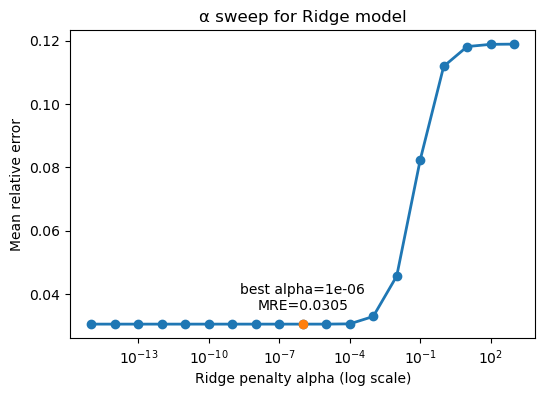

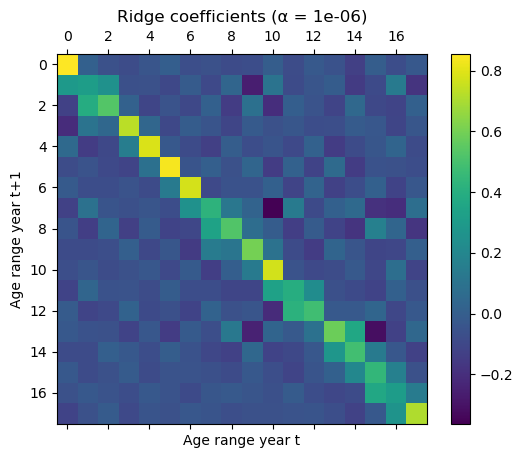

In [5]:
alphas = [10.0**k for k in range(-15, 4)] 
scores = {}
best_alpha, best_mre, best_model = None, float('inf'), None

for a in alphas:
    mre, model = rel_error_for_alpha(a, x_train, y_train, x_test, y_test)
    scores[a] = mre
    if mre < best_mre:
        best_alpha = a
        best_mre = mre
        best_model = model

print(f"Best alpha: {best_alpha} | Best mean relative error: {best_mre:.7f}") 

alphas_sorted = np.array(sorted(scores))
errors_sorted = np.zeros_like(alphas_sorted)
for i in range(len(alphas_sorted)):
    errors_sorted[i] = scores[alphas_sorted[i]]


fig, axis = plt.subplots(figsize=(6, 4))
axis.semilogx(alphas_sorted, errors_sorted, marker='o', linewidth=2)
axis.set_xlabel(r"Ridge penalty alpha (log scale)")
axis.set_ylabel("Mean relative error")
axis.set_title("α sweep for Ridge model")
# highlight best
# ib = np.argmin(errors_sorted)
best_alpha_index = np.argmin(errors_sorted)
axis.plot(alphas_sorted[best_alpha_index], errors_sorted[best_alpha_index], 'o')
axis.annotate(f"best alpha={alphas_sorted[best_alpha_index]:.3g}\nMRE={errors_sorted[best_alpha_index]:.4f}", xy=(alphas_sorted[best_alpha_index], errors_sorted[best_alpha_index]),
            xytext=(0, 10), textcoords="offset points", ha='center')
plt.show()


plt.figure()
plt.matshow(best_model.coef_, fignum=0)
plt.colorbar()
plt.xlabel('Age range year t')
plt.ylabel('Age range year t+1')
plt.title(f'Ridge coefficients (α = {best_alpha:g})')
plt.show()


Quantifying the pattern from the visuals and results. Take the mean along the diagonals.

0.07884557096329285


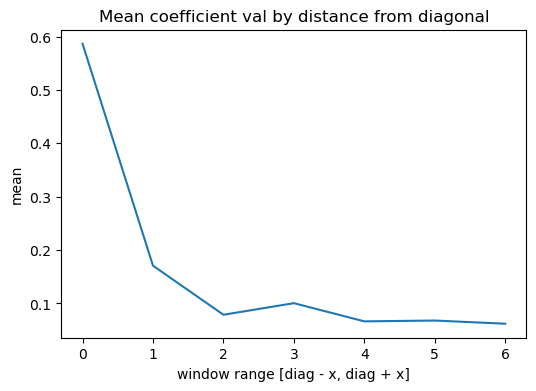

In [4]:
def band_mean_abs(A, k: int) -> float:
    A = np.abs(A)
    band = A.diagonal(offset=k)
    if k > 0:
        band = np.concatenate([band, A.diagonal(offset=-k)])
    return float(band.mean())

def graph_mean_ans_diagnonals(A, num):
    fig, axis = plt.subplots(figsize=(6, 4))
    plot_list = []
    for i in range(num):
        plot_list.append(band_mean_abs(A, i))
    plt.plot(plot_list)
    plt.title("Mean coefficient val by distance from diagonal")
    plt.ylabel("mean")
    plt.xlabel("window range [diag - x, diag + x]")
    plt.show()
    
print(band_mean_abs(best_model.coef_, 2))
graph_mean_ans_diagnonals(best_model.coef_, 7)